**Betrachtetes System**: Pendel mit horizontal verschieblicher Aufhängung ("Wagen-Pendel-System")

<img src="system.svg">

In [1]:
%load_ext ipydex.displaytools
%matplotlib inline

import sympy as sp
from sympy import sin, cos, pi
from sympy.interactive import printing
import numpy as np
import scipy as sc
import scipy.signal as scs
from scipy.integrate import odeint
from scipy.constants import g as gravity
import symbtools as st
import symbtools.modeltools as mt
import matplotlib.pyplot as plt

printing.init_printing(1)

In [2]:
t = sp.Symbol('t')
n_p = 1
n_q = 1
n = n_p + n_q ##:
pp = st.symb_vector(("varphi", ))
qq = st.symb_vector(("q", ))
#aa = st.symb_vector("a1:{0}".format(Nq+1))
#ww = st.symb_vector("w1:{0}".format(Nq+1))

ttheta = st.row_stack(pp, qq) ##:T
tthetad = st.time_deriv(ttheta, ttheta)
tthetadd = st.time_deriv(ttheta, ttheta, order=2)
st.make_global(ttheta, tthetad)

---


---


In [3]:
params = sp.symbols('m1, m2, l, g, q_r, t, T')
st.make_global(params)

u = sp.Symbol("u")

### Festlegung der Geometrie des mechanischen Systemes

In [4]:
#Einheitsvektoren
ex = sp.Matrix([1,0])
ey = sp.Matrix([0,1])

# Koordinaten der Schwerpunkte und Gelenke
S1 = ex * q  # Schwerpunkt Wagen
G2 = S1      # Pendel-Gelenk

# Schwerpunkt des Pendels (Pendel zeigt für kleine Winkel nach oben)
S2 = G2 + mt.Rz(varphi)*ey*l

# Zeitableitungen der Schwerpunktskoordinaten
S1d, S2d  = st.col_split(st.time_deriv(st.col_stack(S1, S2), ttheta))

In [5]:
# Energie
E_rot = 0 # (Punktmassenmodell)
E_trans = (m1*S1d.T*S1d  +  m2*S2d.T*S2d) / 2

E = E_rot + E_trans[0]

V = m2*g*S2[1]

### Zustandsraumdarstellung

___


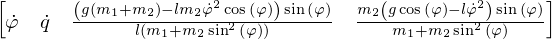

___


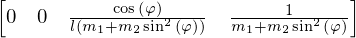

___


In [6]:
mod = mt.generate_symbolic_model(E, V, ttheta, [0, u])
mod.calc_state_eq()
mod.xx ##:
mod.f ##:T
mod.g ##:T

### Linearisierung um die obere Ruhelage

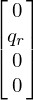

---


---


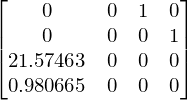

---


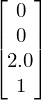

---


In [7]:
eqp = sp.Matrix([0, q_r, 0, 0]) # 1m side stepping ##:

# Parameterwerte
parameter_values = [(g, gravity), (m1, 1), (m2, 0.1), (l, 0.5)]
replm =  parameter_values + list(zip(mod.xx, eqp)) ##:

mod.A = mod.f.jacobian(mod.xx).subs(replm) ##:
mod.b = mod.g.subs(replm) ##:


### Transformation auf Regelungsnormalform

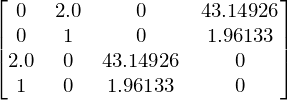

___


---


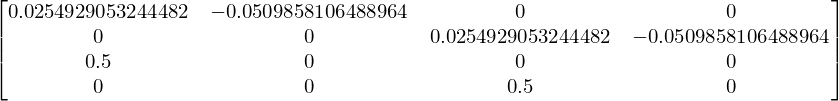

___


In [8]:
Q = sp.Matrix() # Steuerbarkeitsmatrix
for i in range(4):
    Q = Q.col_insert(i, mod.A**i * mod.b)
    
Q ##:
t_ = Q.inv()[-1, :].T ##:T

T_ = sp.Matrix() # Transformationsmatrix 
for i in range(4):
    T_ = T_.row_insert(i, t_.T * mod.A**i)
    
T_ ##:

---


---


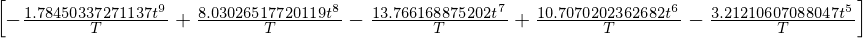

---


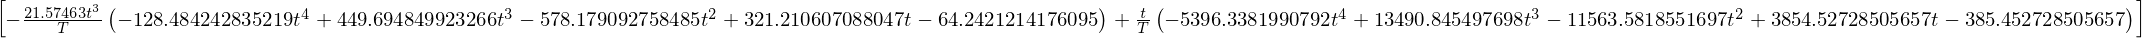

---


In [9]:
za = t_.T * eqp.subs(q_r, 0) ##:
zb = t_.T * eqp.subs(q_r, 0.5) ##:
n = 4
z = za + (zb - za) * np.array([[126, -420, 540, -315, 70]])  * sp.Matrix([t**i / T for i in range(n+1, 2*n+2)]) ##:

Z = sp.Matrix([sp.diff(z, t, i) for i in range(n)])
u = sp.diff(z, t, 4) - t_.T * mod.A**4 * T_.inv() * Z ##:

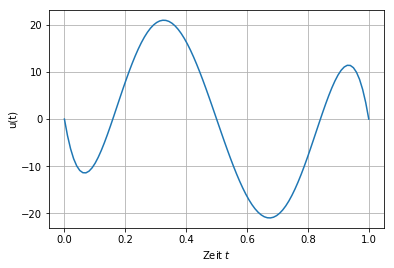

In [10]:
lam_u = sp.lambdify(t, u.subs(T, 1), modules=['numpy'])
x = np.linspace(0, 1, 100)
y = lam_u(x).flatten()

plt.plot(x, y)
plt.grid()
plt.xlabel("Zeit $t$")
plt.ylabel("u(t)")
plt.show()

### Simulation (nicht lineares Modell)

In [11]:
# Zeit-Array und Anfangswerte
tt = np.arange(0, 1.1, 0.1e-3)
tt.shape ##:
xx0 = st.to_np(eqp.subs(q_r, 0.0)).ravel()

#Erstellung des Simulationsmodells
sm = st.SimulationModel(mod.f, mod.g, mod.xx, model_parameters=parameter_values)
rhs1 = sm.create_simfunction(input_function=lam_u)

# Durchführung der Simulation
res = odeint(rhs1, xx0, tt)
X1, X2, X3, X4 = res.T

___


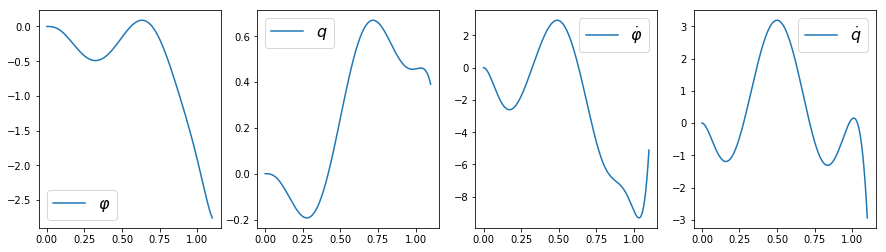

In [12]:
plt.figure(figsize=(15,4))
plt.subplot(1, 4, 1)
plt.plot(tt, X1, label=r"$\varphi$")
plt.legend(loc='best', fontsize=16)
plt.subplot(1, 4, 2)
plt.plot(tt, X2, label="$q$")
plt.legend(loc='best', fontsize=16)
plt.subplot(1, 4, 3)
plt.plot(tt, X3, label=r"$\dot{\varphi}$")
plt.legend(loc='best', fontsize=16)
plt.subplot(1, 4, 4)
plt.plot(tt, X4, label=r"$\dot{q}$")
plt.legend(loc='best', fontsize=16);

### Simulation (linearisiertes Modell)

In [13]:
pendel = scs.StateSpace(np.array(mod.A).astype(np.float64), np.array(mod.b).astype(np.float64), np.eye(4))
_, _, res = scs.lsim2(system=pendel, U=lam_u(tt).flatten(), T=tt)

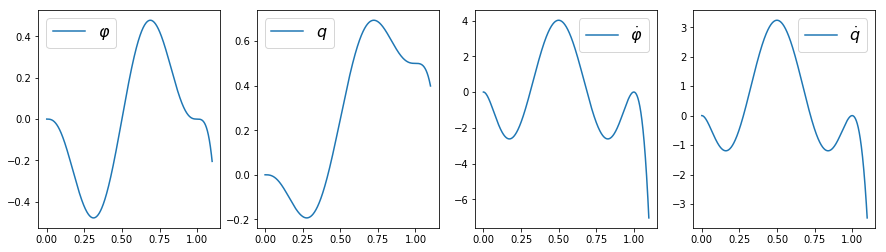

In [14]:
plt.figure(figsize=(15,4))
plt.subplot(1, 4, 1)
plt.plot(tt, res[:, 0], label=r"$\varphi$")
plt.legend(loc='best', fontsize=16)
plt.subplot(1, 4, 2)
plt.plot(tt, res[:, 1], label="$q$")
plt.legend(loc='best', fontsize=16)
plt.subplot(1, 4, 3)
plt.plot(tt, res[:, 2], label=r"$\dot{\varphi}$")
plt.legend(loc='best', fontsize=16)
plt.subplot(1, 4, 4)
plt.plot(tt, res[:, 3], label=r"$\dot{q}$")
plt.legend(loc='best', fontsize=16);

### Generierung von Trainingsdaten

In [15]:
Y = []
X = np.linspace(0.1, 1.0, 100)

for q in X:
    zb = t_.T * eqp.subs(q_r, q)
    z = za + (zb - za) * np.array([[126, -420, 540, -315, 70]]) * sp.Matrix([t**i / T for i in range(n+1, 2*n+2)]) ##:
    Z = sp.Matrix([sp.diff(z, t, i) for i in range(n)])
    u = sp.diff(z, t, 4) - t_.T * mod.A**4 * T_.inv() * Z
    U = sp.Poly(u.subs(T, 1).tolist()[0][0], t)
    Y.append(U.coeffs())

Y = np.array(Y).astype(np.float32)

In [16]:
from lolimot import LolimotRegressor

model_complexity = 150
LLM = []

for i in range(Y.shape[1]):
    llm = LolimotRegressor(model_complexity=model_complexity, notebook=True)
    print(f"***Training von Modell {i}***")
    LLM.append(llm.fit(X=X[:,np.newaxis], y=Y[:, i]))

***Training von Modell 0***



***Training von Modell 1***



***Training von Modell 2***



***Training von Modell 3***



***Training von Modell 4***



***Training von Modell 5***



***Training von Modell 6***


---


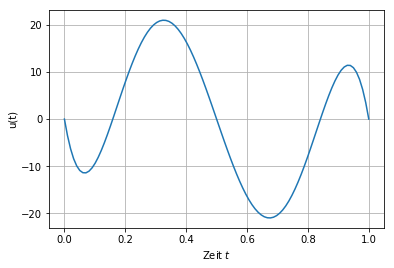

In [17]:
coeffs = np.flip(np.array([llm.predict(0.5) for llm in LLM]), axis=0)
poly = sp.Matrix([t**i for i in range(1, 8)]).T * coeffs ##:

lam_u = sp.lambdify(t, poly, modules=['numpy'])
_, _, res = scs.lsim2(system=pendel, U=lam_u(tt).flatten(), T=tt)

x = np.linspace(0, 1, 100)
y = lam_u(x).flatten()

plt.plot(x, y)
plt.grid()
plt.xlabel("Zeit $t$")
plt.ylabel("u(t)")
plt.show()

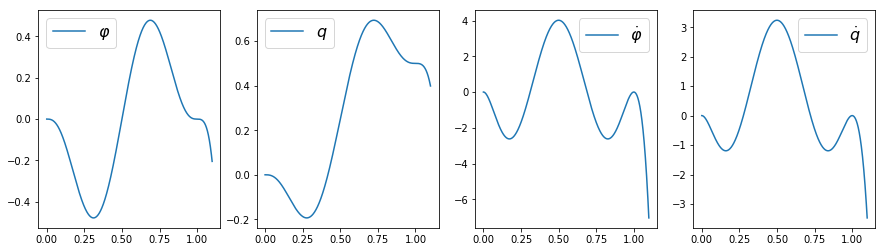

In [18]:
plt.figure(figsize=(15,4))
plt.subplot(1, 4, 1)
plt.plot(tt, res[:, 0], label=r"$\varphi$")
plt.legend(loc='best', fontsize=16)
plt.subplot(1, 4, 2)
plt.plot(tt, res[:, 1], label="$q$")
plt.legend(loc='best', fontsize=16)
plt.subplot(1, 4, 3)
plt.plot(tt, res[:, 2], label=r"$\dot{\varphi}$")
plt.legend(loc='best', fontsize=16)
plt.subplot(1, 4, 4)
plt.plot(tt, res[:, 3], label=r"$\dot{q}$")
plt.legend(loc='best', fontsize=16);

## Überprüfung auf statische Eingangs-Zustands-Linearisierbarkeit

Konstrunktion der Distributionen $\Delta_k$

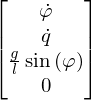

---


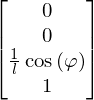

---


---


In [19]:
mod.calc_coll_part_lin_state_eq()
f = mod.ff ##:
G = mod.gg ##:
#g1, g2 = st.col_split(G)

xx = mod.x ##:T

In [20]:
nx = len(xx)

# Liste der Distributionen
# (mit Eingangsvektorfeldern starten (Delta_0 = G) )
Delta_list = [G]

for k in range(1, nx):
    Delta_j_full = Delta_list[-1]
    Delta_j = Delta_j_full[:, -n_q:]# nur die letzten n_q Spalten für Lieklammer relevant
    Delta_k = []
    for vf in st.col_split(Delta_j):
        Delta_k.append(st.lie_bracket(f, vf, xx))
    
    # neu berechnete VF zusammen mit bisherigen in Matrix konvertieren
    Delta_k = st.col_stack(Delta_j_full, *Delta_k)
    Delta_list.append(Delta_k)

In [22]:
for i, D in enumerate(Delta_list):
    print(f"dim(Delta_{i}) = {st.rnd_number_rank(D)}")
    
    # failing_vf enthält die ersten beiden VF, deren Lie-Klammer nicht in der Distribution liegen
    inv_flag, failing_vf = st.involutivity_test(D, xx)
    print(f"Delta_{i} involutiv? {inv_flag}\n")

dim(Delta_0) = 1
Delta_0 involutiv? True

dim(Delta_1) = 2
Delta_1 involutiv? False

dim(Delta_2) = 3
Delta_2 involutiv? False

dim(Delta_3) = 4
Delta_3 involutiv? True

